# Synthesize Detected Intensities
Compute synthesized intensity maps using our fake Hi-C instrument and our hydrodynamic simulations

In [1]:
import time
import sys
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
import traceback

import numpy as np
from scipy.interpolate import splprep,splev
import toolz
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.animation
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar
import sunpy.sun.constants as sun_const
import sunpy.map
import sunpy
from scipy.interpolate import splrep,splev
import dask
import distributed
from IPython.display import HTML

import synthesizAR
from hi_c import InstrumentHiC,CustomEmissionModel

%matplotlib inline
#%load_ext snakeviz

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load in both the emission model and the active region

In [2]:
active_region = synthesizAR.Field.restore('/storage-home/w/wtb2/data/hi_c_simulation/field_checkpoint/')

In [3]:
em_model = CustomEmissionModel.restore('/storage-home/w/wtb2/data/hi_c_simulation/emission_model.json')

Need to modify observer a bit so that we avoid a bunch of unneeded interpolation.

In [4]:
class Observer(synthesizAR.Observer):
    
    def _interpolate_loops(self, ds):
        """
        Don't interpolate, just load them from the loops. The resolution is already sufficiently high.
        """
        # Interpolate all loops in HEEQ coordinates
        total_coordinates = []
        interpolated_loop_coordinates = []
        for loop in self.field.loops:
            interpolated_loop_coordinates.append(loop.field_aligned_coordinate.to(u.cm).value)
            total_coordinates.append(loop.coordinates.cartesian.xyz.value.T)

        total_coordinates = np.vstack(total_coordinates) * loop.coordinates.cartesian.xyz.unit

        return total_coordinates, interpolated_loop_coordinates
    
    def _flatten_detector_counts_parallel(self, **kwargs):
        """
        Build custom Dask graph interpolating quantities for each in loop in time and space.
        """
        emission_model = kwargs.get('emission_model', None)
        interpolate_hydro_quantities = kwargs.get('interpolate_hydro_quantities', True)
        futures = {}
        for instr in self.instruments:
            futures[f'{instr.name}'] = instr.flatten_parallel(
                self.field.loops,self._interpolated_loop_coordinates, emission_model=emission_model)

        return futures

In [5]:
hic = InstrumentHiC([2.5e4,3e4]*u.s,active_region.magnetogram.observer_coordinate,
                    fov={'min_x': -235*u.arcsec, 'max_x': -15*u.arcsec,
                         'min_y': 160*u.arcsec, 'max_y': 380*u.arcsec})

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


In [6]:
obs = Observer(active_region,[hic],parallel=True)

In [7]:
cluster = distributed.LocalCluster(threads_per_worker=1,n_workers=32,memory_limit='8GB')
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46212 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 32 Memory: 256.00 GB


### Flatten Counts

In [8]:
obs.build_detector_files('/storage-home/w/wtb2/data/hi_c_simulation/',None)

In [ ]:
flatten_futures = obs.flatten_detector_counts(emission_model=em_model, interpolate_hydro_quantities=False)

In [ ]:
# Find any failed runs, need to rerun them
failures = []
for i,f in enumerate(flatten_futures['Hi_C']):
    if f.status != 'finished':
        print(i,f.status)
        failures.append(i)
        #print(f.exception())
        #print(traceback.print_stack(f.traceback()))

In [ ]:
start_indices = np.insert(np.array(
            [s.shape[0] for s in obs._interpolated_loop_coordinates]).cumsum()[:-1], 0, 0)

In [ ]:
flat_emissivities = hic.flatten_emissivities(hic.channels[0],em_model)

In [ ]:
failed_futures = []
for f in failures:
    failed_futures.append(hic.calculate_counts(
        hic.channels[0], active_region.loops[f], start_indices[f], em_model, flat_emissivities,
    ))

### Bin Counts

In [9]:
bin_futures = obs.bin_detector_counts('/storage-home/w/wtb2/data/hi_c_simulation/')

In [10]:
bin_futures['Hi_C']['171'][0].exception()

NameError("name 'Map' is not defined")

### Sandbox

In [24]:
m = sunpy.map.Map('/storage-home/w/wtb2/data/hi_c_simulation/Hi_C/171/map_t000300.fits')
#m = m.submap(SkyCoord(-250*u.arcsec,160.*u.arcsec,frame=m.coordinate_frame),
#             SkyCoord(0.*u.arcsec,380*u.arcsec,frame=m.coordinate_frame))

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/ipykernel/__main__.py:3: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  app.launch_new_instance()


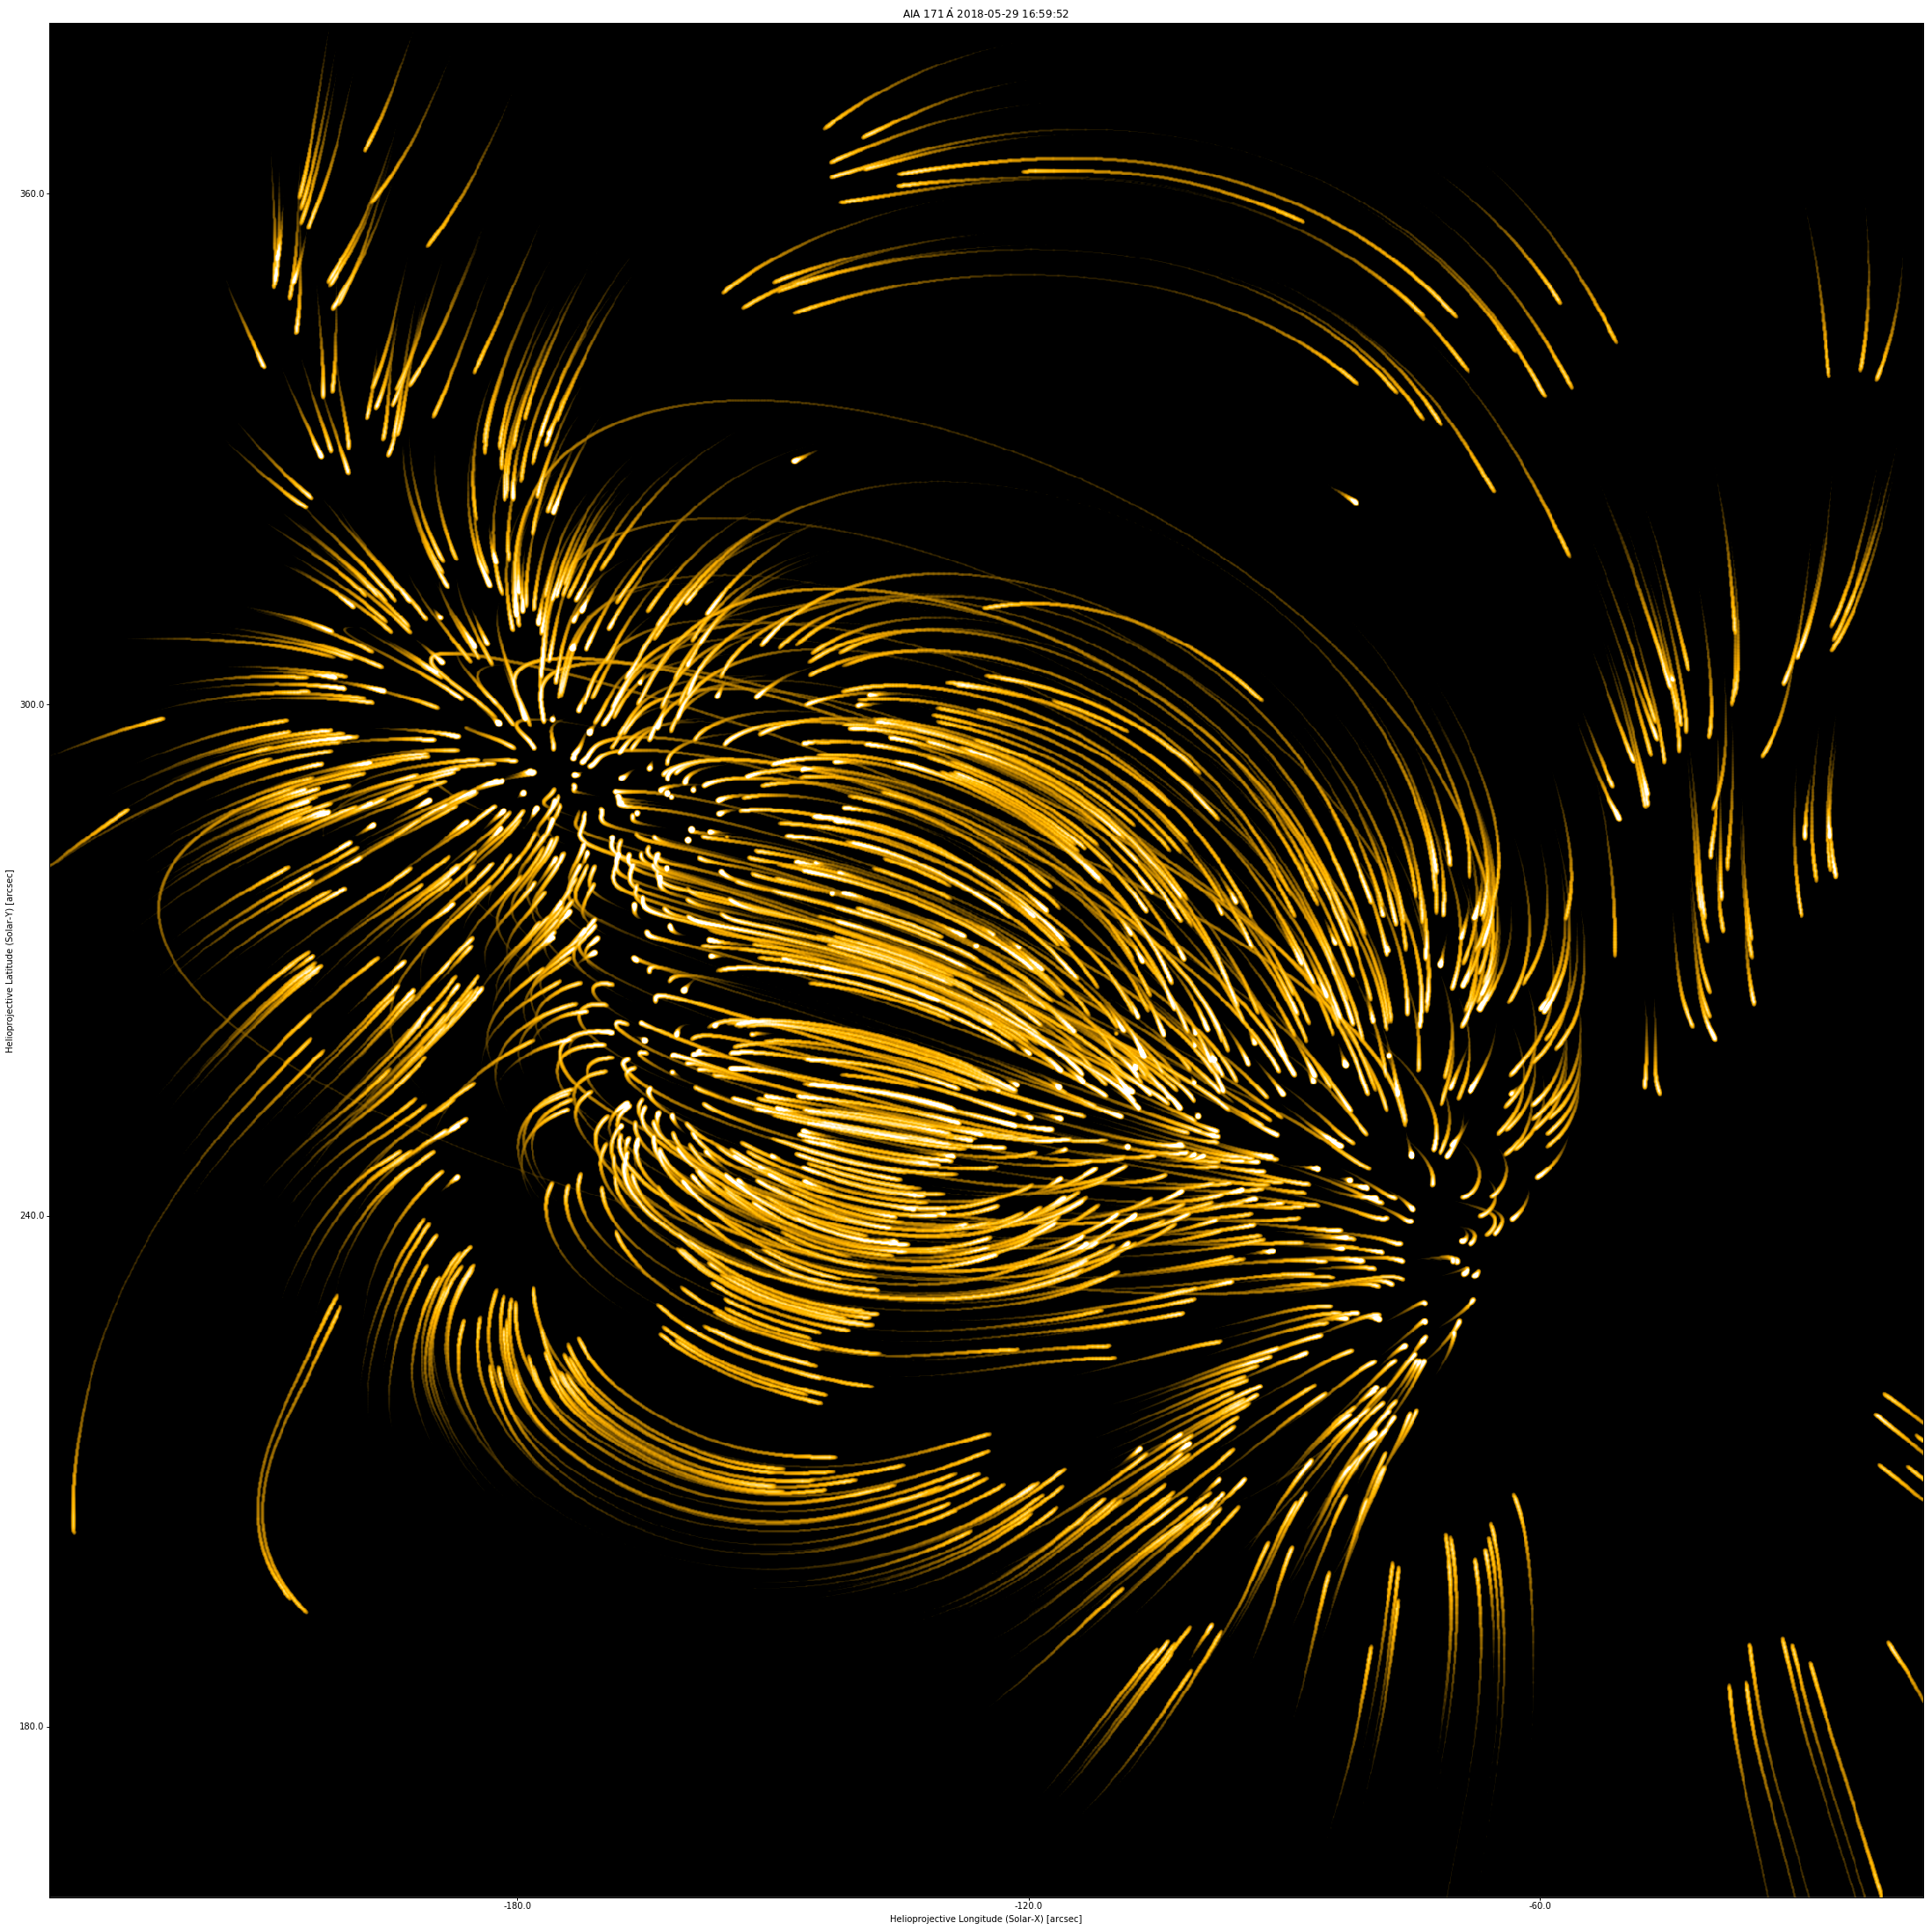

In [32]:
fig = plt.figure(figsize=(30,30))
ax = fig.gca(projection=m)
m.plot(axes=ax,cmap=sunpy.cm.get_cmap('sdoaia171'),
       norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e-2,vmax=1e1))
ax.grid(alpha=0)
plt.tight_layout()
plt.savefig('hi_c_171_map.pdf',bbox_inches='tight')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/ipykernel/__main__.py:6: SunpyDeprecationWarning: Use Matplotlib to load the colormaps


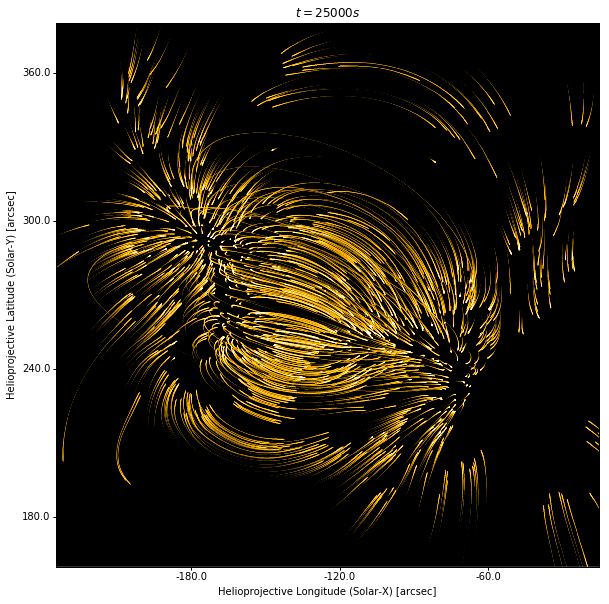

In [30]:
fig = plt.figure(figsize=(10,10))
m = sunpy.map.Map('/storage-home/w/wtb2/data/hi_c_simulation/Hi_C/171/map_t000000.fits')
#m = m.submap(SkyCoord(-270*u.arcsec,170.*u.arcsec,frame=m.coordinate_frame),
#             SkyCoord(0.*u.arcsec,370*u.arcsec,frame=m.coordinate_frame))
ax = fig.gca(projection=m)
im = m.plot(axes=ax,cmap=sunpy.cm.get_cmap('sdoaia171'),
            norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e-2,vmax=1e1),
            title=False)
ax.grid(alpha=0)
def update(i):
    m = sunpy.map.Map(f'/storage-home/w/wtb2/data/hi_c_simulation/Hi_C/171/map_t{i:06d}.fits')
    #m = m.submap(SkyCoord(-270*u.arcsec,170.*u.arcsec,frame=m.coordinate_frame),
    #             SkyCoord(0.*u.arcsec,370*u.arcsec,frame=m.coordinate_frame))
    im.set_data(m.data)
    ax.set_title(f'$t={hic.observing_time[i]:.0f}$')
    return im,
anim = matplotlib.animation.FuncAnimation(fig,update,frames=hic.observing_time.shape[0],
                                          blit=True, repeat=True, interval=20)

In [31]:
anim.save('hi_c_movie.mp4',writer='ffmpeg',)#dpi=75,)